# Assignment 10

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

---

#### ``Objectives``
1. Implement a CNN to detect diabetic retinopathy (DR) from retina images taken using fundus photography under a variety of imaging conditions.
2. Improve generalization performance and reduce overfitting using **image transformation** and **data augmentation** techniques.

#### ``Motivation``

Diabetic retinopathy (DR) is an eye condition that  affects blood vessels in the retina. It can cause vision loss and blindness in people who have diabetes. Screening for DR allows earlier and more effective treatment options for millions of people.

#### ``Data``

In this assignment you will use a small dataset of retina images (`Download` links: [images](https://drive.google.com/drive/folders/1sdfUC64Un1iwuiHEehcbijxB54OhU_nd?usp=sharing) and [labels](https://drive.google.com/drive/folders/1MOlSJBZg7L1HtG5vHPt77ighRvQaGfDg?usp=sharing)). You will **build** and **train** a **CNN model** to predict whether or not to refer a patient for DR treatment using binarized severity of DR in patients: no referral if {No DR, mild} and referral if {moderate, severe, and proliferate DR}.


<u>Note</u>: the original dataset is hosted by Kaggle [[Source]](https://www.kaggle.com/c/aptos2019-blindness-detection/).

Import the necessary libraries and make sure to replace IMAGE_PATH and LABEL_PATH with the path to the directories where you saved the data.

---
### Step 1: Import libraries

In [1]:
!unzip CNN_images.zip

Archive:  CNN_images.zip
replace CNN_images/1caba2fb38f6.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
IMAGE_PATH = '/content/CNN_images' # replace with your path
LABEL_PATH = '/content/labels.csv' # replace with your path

At this point, you may ask yourself what the best model that fits this data is. First, you will want to read through the data description in Kaggle (see the link to the original dataset above). Understanding what you are working with challenges you to write preprocessing code that uncovers your data's most helpful information.

---
#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Read the data description from Kaggle and list (a) the source of images and (b) the labeling procedure.

The images were taken using fundus photography by Aravind technicians

The labels were rated by a clinician based on severity

---
### Step 2: Data ingestion

Let's load the 2D images and their corresponding labels.

``labels``

In [3]:
labels_df = pd.read_csv(
    LABEL_PATH
)

print('Shape of labels:', labels_df.shape)
print('Unique diagnosis codes:', np.sort(labels_df.diagnosis.unique()))
labels_df.head()

Shape of labels: (200, 2)
Unique diagnosis codes: [0 1 2 3 4]


,id_code,diagnosis
0,000c1434d8d7,2
1,0024cdab0c1e,1
2,0083ee8054ee,4
3,00a8624548a9,2
4,00b74780d31d,2


There are 200 training images corrresponding to 5 different diabetic retinopathy (DR) diagnosis codes:

* No DR (0)
* mild (1)
* moderate (2)
* severe (3)
* proliferate DR (4)


``images``

In [4]:
images = []

for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    img = load_img(
    IMAGE_PATH + '/' + img)
    images.append(img)

---
### Step 3: Exploratory Data Analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot a histogram for the five classes of DR. Are the classes balanced?

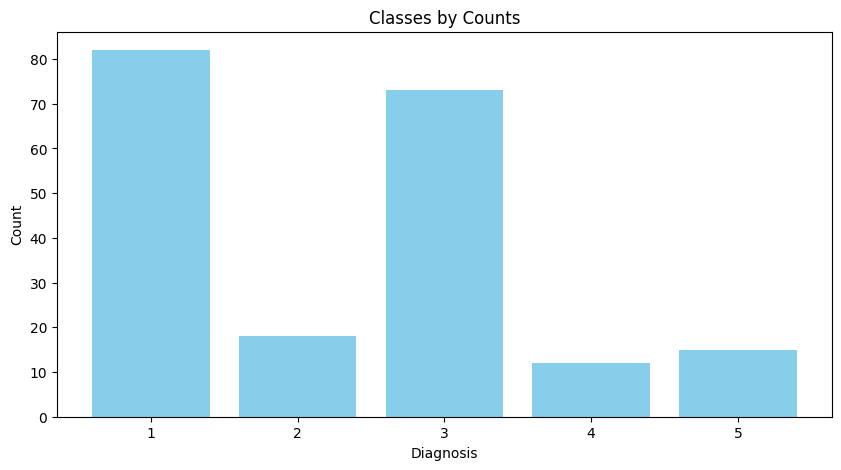

In [5]:
#count the unique classes
class_counts = labels_df['diagnosis'].value_counts()

plt.figure(figsize=(10,5))
plt.bar(class_counts.index + 1, class_counts.values, color='skyblue')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Classes by Counts')
plt.show()

Comment on class balance: This has terrible class balance. The majority of the dataset are 1's and 3's.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Print 8 images from the data. What can you say about the size, focus/orientation of these images?

In [6]:
# Function that takes in an image and amount and displayes them
def show_images(images, num_of_image = 8):
  #make a figre
  plt.figure(figsize = (10,8))
  #loop through desired length of images
  for i in range(num_of_image):
    # Create a subplot in the 2x4 grid at position i+1
    plt.subplot(2, 4, i + 1)
    # Image
    plt.imshow(images[i])
    plt.axis('off')
  # Display images
  plt.show()

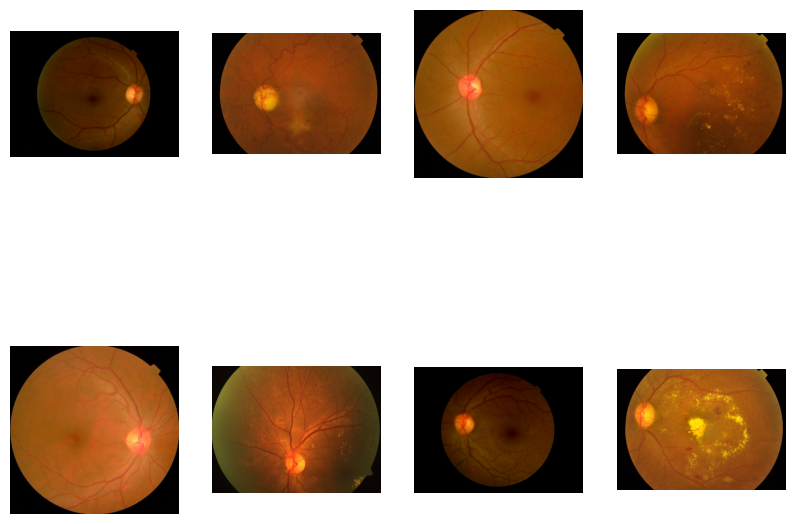

In [7]:
show_images(images, 8)

Comment on the size, focus/orientation of the 8 images:

*   Size: Looks like the images range in sizes
*   Focus: Some retnias apear to be more focused/ zoomed in and out than others
*   Orientation: Retnas seem to be looking at different directions
*   Shape: Most images are rectangular while some are squared







---
### Step 4: Data preprocessing

First, we will correct for class imbalance. Note that imbalanced data is common in healthcare, and it happens because some diseases are rare. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We will correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}


  * Second, we'll only take 80 random samples from the 'no refer' class and 80 from the 'refer' class.

It is a crude method to deal with imbalanced data, but it will be good enough for this homework.

In [8]:
# Set the random seed for reproducibility
np.random.seed(1234)

# Filter the labels DataFrame to create two separate DataFrames:
# - no_refer: contains rows where the 'diagnosis' column is either 0 or 1 (no referral needed)
# - refer: contains rows where the 'diagnosis' column is 2, 3, or 4 (referral needed)
no_refer = labels_df[labels_df.diagnosis.isin((0, 1))]
refer = labels_df[labels_df.diagnosis.isin((2, 3, 4))]

# Randomly select 80 image IDs from the 'no_refer' DataFrame without replacement
# This ensures that the same image ID is not selected more than once
temp_no_refer = list(np.random.choice(
    no_refer.id_code,  # The array of image IDs to choose from
    size=80,           # The number of image IDs to randomly select
    replace=False      # Do not allow duplicate selections
))

# Randomly select 80 image IDs from the 'refer' DataFrame without replacement
# This ensures that the same image ID is not selected more than once
temp_refer = list(np.random.choice(
    refer.id_code,     # The array of image IDs to choose from
    size=80,           # The number of image IDs to randomly select
    replace=False      # Do not allow duplicate selections
))


Next, we will use the ``preprocess_data_part1()`` function defined below to generate lists of images and labels (images_mini and y_mini) based on the values in the temp_no_refer and temp_refer lists. Note that the size of the image is set to (224, 224).

In [9]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer):
    """
    Generate lists of images and labels based on temp_no_refer and temp_refer lists.

    Params:
    -------
    IMAGE_PATH (str): Path to the directory with images.
    LABEL_PATH (str): Path to the directory with labels.
    temp_no_refer (list): List of labels for the no refer category.
    temp_refer (list): List of labels for the refer category.

    Returns:
    --------
    images_mini (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)
    """

    # Initialize empty lists to store images and their corresponding labels
    y_mini = []
    images_mini = []

    # Iterate through each file in the IMAGE_PATH directory
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # Extract the image ID by splitting the file name (assuming format 'id.extension')
        img_id = img.split('.')[0]

        # Determine the label for the image based on its ID
        if img_id in temp_no_refer:
            y_mini.append(0)  # Append 0 for 'no refer' category
        elif img_id in temp_refer:
            y_mini.append(1)  # Append 1 for 'refer' category
        else:
            continue  # Skip the image if it's not in either category

        # Load the image and resize it to the target size of (224, 224)
        img_path = os.path.join(IMAGE_PATH, img)  # Construct the full path to the image
        img = load_img(img_path, target_size=(224, 224))

        # Convert the image to a numpy array
        img = img_to_array(img)

        # Append the image array to the images_mini list
        images_mini.append(img)

    # Stack the list of image arrays into a single numpy array
    images_mini = np.stack(images_mini)

    # Convert the list of labels to a numpy array and flatten it to ensure it's 1-dimensional
    y_mini = np.array(y_mini).flatten()

    # Return the arrays of images and labels
    return images_mini, y_mini

In [10]:
# generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(
    IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer
)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (160, 224, 224, 3)
y_mini shape (160,)


#### <span style="color:chocolate"> Exercise 4 (20 points) </span>

Create train, validation, and test data. Implement the `preprocess_data_part2()` function according to the following guidelines:

1. shuffle images and labels before splitting the data

2. use a (0.6,0.2,0.2)train/validation/test set split

3. perform image transformation and augmentation, as follows:
    * Applied on training set only:
         - create additional copies (augmentations) of the training images by flipping left right each image (Hint: use the method available in the tf.image module).
         - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 192 images and labels.
    * Applied on training, validation, and test sets:
        - rescale images by dividing each pixel by 255.0

Reason for doing image augmentation: The quantity and diversity of data gathered significantly impact the results of a CNN model. One can use augmentations to artificially inflate the training dataset by warping the original data so that their label does not change. These augmentations can significantly improve learning results without collecting new data.

In [11]:
def preprocess_data_part2(images, labels, splits):
    """
    Split data into train, validation, and test sets; apply transformations and augmentations.

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    labels (np.ndarray): Labels of shape (N,)
    splits (tuple): 3 values summing to 1 defining split of train, validation, and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    """

    # Set random seeds for reproducibility
    tf.random.set_seed(1234)
    np.random.seed(1234)


    indices = np.arange(len(images))  # Generate indices based on the number of samples
    np.random.shuffle(indices)  # Shuffle the indices
    shuffled_images = images[indices]  # Shuffle images according to the shuffled indices
    shuffled_labels = labels[indices]  # Shuffle labels according to the shuffled indices

    # Create data splits (training, validation, and test sets)
    num_of_samples = len(shuffled_images)  # Calculate the total number of samples
    train_end = int(num_of_samples * splits[0])  # Calculate the end index for the training set
    val_end = train_end + int(num_of_samples * splits[1])  # Calculate the end index for the validation set

    # Split the data
    X_train = shuffled_images[:train_end]  # Training images
    y_train = shuffled_labels[:train_end]  # Training labels
    X_val = shuffled_images[train_end:val_end]  # Validation images
    y_val = shuffled_labels[train_end:val_end]  # Validation labels
    X_test = shuffled_images[val_end:]  # Test images
    y_test = shuffled_labels[val_end:]  # Test labels

    # Image augmentation (random flip) on training data
    X_train_augm = tf.image.flip_left_right(X_train)  # Flip training images left to right

    # Concatenate original X_train and augmented X_train_augm data
    X_train = tf.concat([X_train, X_train_augm], axis=0)  # Concatenate along the first dimension

    # Concatenate y_train (note the label is preserved)
    y_train_augm = y_train  # Duplicate y_train labels
    y_train = tf.concat([y_train, y_train_augm], axis=0)  # Concatenate along the first dimension

    # Shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))  # Create a shuffled index
    X_train = tf.gather(X_train, shuffle).numpy()  # Transform X back to numpy array instead of tensor
    y_train = tf.gather(y_train, shuffle).numpy()  # Transform y back to numpy array instead of tensor

    # Rescale training, validation, and test images by dividing each pixel by 255.0
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0

    return X_train, y_train, X_val, y_val, X_test, y_test

In [12]:
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (192, 224, 224, 3)
y_train shape (192,)
X_val shape (32, 224, 224, 3)
y_val shape (32,)
X_test shape (32, 224, 224, 3)
y_test shape (32,)


---
### Step 5: Modeling

#### <span style="color:chocolate"> Exercise 5 (20 points) </span>

The objective is to build and train a CNN model to refer patients to doctors based on the severity of DR seen in these images. You are interested in exploring binary classification of 'no refer' and 'refer'.

Implement a CNN classifier according to the following guidelines (let's call this model1; this model will serve as our baseline classifier):

1. Implement this model using the TF Keras API.
1. The model receives input images of size 224 x 224 x 3 (that is, the images have three color channels)
2. The input data goes through one convolutional layer that has the following specifications:
    - filters = 12
    - kernel_size = (4 x 4)
    - strides = (1, 1)
    - padding = 'same'
    - data_format = 'channels_last'
    - name = 'conv_1'
    - activation = 'relu'
3. The convolutional layer is followed by a max-pooling layer with pool_size = (2,2). Note: this will reduce the size of the feature maps.
4. The max-pooling layer is followed by a dropout layer with rate = 0.3.
5. The dropout layer is followed by a flattening layer.
6. The last layer of the model is the classification head.
7. Build and compile the model using the Adam optimizer and learning_rate = 0.1. Print summary of the model.
8. Train the model on (X_train, y_train) data for 20 epochs. Add early stopping (Hint: pass the early_stopping implementation below to the fit() method as "callbacks=[early_stopping]").
9. How many parameters does the model have?
10. Evaluate the accuracy of the model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation datasets.

In [13]:
# Define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor: The metric to monitor during training.
    # In this case, it will monitor 'accuracy'.
    monitor='accuracy',

    # verbose: Controls the verbosity of the output.
    # With verbose=1, messages will be printed when training is stopped early.
    verbose=1,

    # patience: Number of epochs with no improvement after which training will be stopped.
    # Here, training will stop if there's no improvement in 'accuracy' for 4 consecutive epochs.
    patience=4,

    # mode: One of {'auto', 'min', 'max'}.
    # - 'min': training will stop when the quantity monitored has stopped decreasing.
    # - 'max': training will stop when the quantity monitored has stopped increasing.
    # - 'auto': mode is automatically inferred from the name of the monitored quantity.
    # Since we're monitoring 'accuracy', which we want to maximize, we use 'max'.
    mode='max',

    # restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity.
    # If True, the model weights obtained at the epoch with the best monitored value will be restored.
    restore_best_weights=True
)


In [14]:
# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize the sequential model
model1 = tf.keras.Sequential()

# Add the first convolutional layer
model1.add(tf.keras.layers.Conv2D(
    filters=12,               # Number of output filters (12 filters)
    kernel_size=(4, 4),       # Size of the 2D convolution window (4x4)
    strides=(1, 1),           # Stride of the convolution along height and width (1, 1)
    padding='same',           # Padding type ('same' means output has the same width and height as input)
    data_format='channels_last',  # Format of the input data (channels_last means (batch, height, width, channels))
    name='conv_1',            # Name of the layer
    activation='relu'         # Activation function (ReLU introduces non-linearity)
))

# Add a max pooling layer
model1.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),         # Size of the max pooling window (2x2)
    name='max_pooling_1'      # Name of the layer
))

# Add a dropout layer
model1.add(tf.keras.layers.Dropout(
    rate=0.3,                 # Dropout rate (30% of the neurons will be randomly set to zero during training)
    name='dropout_1'          # Name of the layer
))

# Add a flattening layer
model1.add(tf.keras.layers.Flatten(
    name='flatten_1'          # Name of the layer
))

# Add a fully connected (dense) layer
model1.add(tf.keras.layers.Dense(
    units=128,                # Number of neurons (128 units)
    activation='relu',        # Activation function (ReLU)
    name='dense_1'            # Name of the layer
))

# Add the output layer
model1.add(tf.keras.layers.Dense(
    units=1,                  # Number of neurons (1 unit for binary classification)
    activation='sigmoid',     # Activation function (Sigmoid outputs a probability between 0 and 1)
    name='output'             # Name of the layer
))

# Build and compile the model
model1.build(input_shape=(None, 224, 224, 3))  # Specify the input shape (batch size, height, width, channels)
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),  # Optimizer (Adam with a learning rate of 0.1)
    loss=tf.keras.losses.BinaryCrossentropy(),              # Loss function (Binary Crossentropy for binary classification)
    metrics=['accuracy']                                    # Metrics to evaluate during training and testing (accuracy)
)

# Print the model summary
model1.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 12)      588       
                                                                 
 max_pooling_1 (MaxPooling2  (None, 112, 112, 12)      0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 12)      0         
                                                                 
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 128)               19267712  
                                                                 
 output (Dense)              (None, 1)                 129       
                                                        

In [15]:
# Train the model on the training data
history = model1.fit(
    X_train,             # Training data
    y_train,             # Training labels
    epochs=20,           # Number of epochs to train
    validation_data=(X_val, y_val),  # Validation data and labels
    callbacks=[early_stopping]       # Callback for early stopping
)

# Evaluate the model on the training data
train_loss, train_accuracy = model1.evaluate(X_train, y_train)
print(f"Training loss: {train_loss}, Training accuracy: {train_accuracy}")

# Evaluate the model on the validation data
val_loss, val_accuracy = model1.evaluate(X_val, y_val)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

Epoch 1/20
6/6 [==============================] - 11s 2s/step - loss: 2314.0061 - accuracy: 0.5521 - val_loss: 0.6839 - val_accuracy: 0.5625
Epoch 2/20
6/6 [==============================] - 7s 1s/step - loss: 0.6948 - accuracy: 0.5312 - val_loss: 0.6895 - val_accuracy: 0.5625
Epoch 3/20
6/6 [==============================] - 9s 2s/step - loss: 0.7034 - accuracy: 0.4271 - val_loss: 0.6870 - val_accuracy: 0.5625
Epoch 4/20
6/6 [==============================] - 7s 1s/step - loss: 0.6953 - accuracy: 0.5312 - val_loss: 0.6863 - val_accuracy: 0.5625
Epoch 5/20
6/6 [==============================] - 9s 1s/step - loss: 0.6949 - accuracy: 0.5312 - val_loss: 0.6941 - val_accuracy: 0.4375
Epoch 5: early stopping
6/6 [==============================] - 2s 297ms/step - loss: 0.6947 - accuracy: 0.5312
Training loss: 0.6947061419487, Training accuracy: 0.53125
1/1 [==============================] - 1s 575ms/step - loss: 0.6839 - accuracy: 0.5625
Validation loss: 0.6838873624801636, Validation accura

How many parameters does model1 have? 19,268,429

Comment on model1 accuracy on training vs. validation data:


Training loss: 0.69, Training accuracy: 0.53


Validation loss: 0.68, Validation accuracy: 0.56

Higher validation accuracy signals light overfitting

#### <span style="color:chocolate"> Exercise 6 (20 points) </span>

Next, you will build a model with a more complex CNN architecture than the baseline CNN classifier above. Your tasks are as follows:

1. Implement this more complex CNN model (call this model2). Note that you are free to experiment with the number of hidden convolutional layers and hyperparameter values. The only requirement is that the minimum number of parameters be greater than 1M.
2. Explain how your implementation differs from the baseline CNN classifier.
3. Train the model on (X_train, y_train) data for 20 epochs. Add early stopping (Hint: pass the early_stopping implementation above to the fit() method as "callbacks=[early_stopping]").
4. How many parameters does the model have?
5. Evaluate the accuracy of the model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation performance relative to the baseline model.

In [42]:
# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize the sequential model
model2 = tf.keras.Sequential()

# Add the first convolutional layer
model2.add(tf.keras.layers.Conv2D(
    filters=12,               # Number of output filters (12 filters)
    kernel_size=(4, 4),       # Size of the 2D convolution window (4x4)
    strides=(1, 1),           # Stride of the convolution along height and width (1, 1)
    padding='same',           # Padding type ('same' means output has the same width and height as input)
    data_format='channels_last',  # Format of the input data (channels_last means (batch, height, width, channels))
    name='conv_1',            # Name of the layer
    activation='relu'         # Activation function (ReLU introduces non-linearity)
))

# Add a max pooling layer
model2.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),         # Size of the max pooling window (2x2)
    name='max_pooling_1'      # Name of the layer
))

# Add a dropout layer
model2.add(tf.keras.layers.Dropout(
    rate=0.3,                 # Dropout rate (30% of the neurons will be randomly set to zero during training)
    name='dropout_1'          # Name of the layer
))

# Add a flattening layer
model2.add(tf.keras.layers.Flatten(
    name='flatten_1'          # Name of the layer
))

# Add a fully connected (dense) layer
model2.add(tf.keras.layers.Dense(
    units=128,                # Number of neurons (128 units)
    activation='relu',        # Activation function (ReLU)
    name='dense_1'            # Name of the layer
))

# Add a fully connected (dense) layer
model2.add(tf.keras.layers.Dense(
    units=32,                # Number of neurons (128 units)
    activation='relu',        # Activation function (ReLU)
    name='dense_2'            # Name of the layer
))

# Add a dropout layer
model2.add(tf.keras.layers.Dropout(
    rate=0.5,                 # Dropout rate (30% of the neurons will be randomly set to zero during training)
    name='dropout_2'          # Name of the layer
))

# Add the output layer
model2.add(tf.keras.layers.Dense(
    units=1,                  # Number of neurons (1 unit for binary classification)
    activation='sigmoid',     # Activation function (Sigmoid outputs a probability between 0 and 1)
    name='output'             # Name of the layer
))

# Build and compile the model
model2.build(input_shape=(None, 224, 224, 3))  # Specify the input shape (batch size, height, width, channels)
model2.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0015),  # Optimizer (Adam with a learning rate of 0.1)
    loss=tf.keras.losses.BinaryCrossentropy(),              # Loss function (Binary Crossentropy for binary classification)
    metrics=['accuracy']                                    # Metrics to evaluate during training and testing (accuracy)
)

# Print the model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 12)      588       
                                                                 
 max_pooling_1 (MaxPooling2  (None, 112, 112, 12)      0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 12)      0         
                                                                 
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 128)               19267712  
                                                                 
 output (Dense)              (None, 1)                 129       
                                                        

In [43]:
# Train the model with data augmentation
history2 = model2.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Evaluate the model on the training data
train_loss, train_accuracy = model2.evaluate(X_train, y_train)
print(f"Training loss: {train_loss}, Training accuracy: {train_accuracy}")

# Evaluate the model on the validation data
val_loss, val_accuracy = model2.evaluate(X_val, y_val)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

Epoch 1/30
6/6 [==============================] - 9s 1s/step - loss: 0.7022 - accuracy: 0.4948 - val_loss: 0.6835 - val_accuracy: 0.5625
Epoch 2/30
6/6 [==============================] - 8s 1s/step - loss: 0.6861 - accuracy: 0.5625 - val_loss: 0.6860 - val_accuracy: 0.5625
Epoch 3/30
6/6 [==============================] - 9s 2s/step - loss: 0.6875 - accuracy: 0.5625 - val_loss: 0.6845 - val_accuracy: 0.7812
Epoch 4/30
6/6 [==============================] - 7s 1s/step - loss: 0.6847 - accuracy: 0.6094 - val_loss: 0.6752 - val_accuracy: 0.8125
Epoch 5/30
6/6 [==============================] - 9s 2s/step - loss: 0.6723 - accuracy: 0.5990 - val_loss: 0.6660 - val_accuracy: 0.7500
Epoch 6/30
6/6 [==============================] - 7s 1s/step - loss: 0.6567 - accuracy: 0.7083 - val_loss: 0.6550 - val_accuracy: 0.7188
Epoch 7/30
6/6 [==============================] - 9s 2s/step - loss: 0.6584 - accuracy: 0.6302 - val_loss: 0.6431 - val_accuracy: 0.8125
Epoch 8/30
6/6 [=========================

How many parameters does model2 have? 19,268,429

Comment on model2 performance on training vs. validation performance relative to the baseline model:

Training loss: 0.36, Training accuracy: 0.85

Validation loss: 0.42, Validation accuracy: 0.84

---
### Step 6: Evaluation

#### <span style="color:chocolate"> Exercise 7 (10 points) </span>

You will now use the test data to evaluate the performance (accuracy) of model1 and model2 on unseen data. Which model performs best? Is this result expected?

In [25]:
# Evaluate the model on the training data
train_loss, train_accuracy = model1.evaluate(X_train, y_train)
print(f"Training loss: {train_loss}, Training accuracy: {train_accuracy}")

# Evaluate the model on the validation data
val_loss, val_accuracy = model1.evaluate(X_val, y_val)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

# Evaluate the model on the validation data
test_loss, test_accuracy = model1.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


6/6 [==============================] - 3s 405ms/step - loss: 0.6951 - accuracy: 0.5312
Training loss: 0.6950882077217102, Training accuracy: 0.53125
1/1 [==============================] - 1s 568ms/step - loss: 0.6856 - accuracy: 0.5625
Validation loss: 0.6856356859207153, Validation accuracy: 0.5625
1/1 [==============================] - 1s 544ms/step - loss: 0.7462 - accuracy: 0.3438
Test loss: 0.746218204498291, Test accuracy: 0.34375


In [44]:
# Evaluate the model on the training data
train_loss, train_accuracy = model2.evaluate(X_train, y_train)
print(f"Training loss: {train_loss}, Training accuracy: {train_accuracy}")

# Evaluate the model on the validation data
val_loss, val_accuracy = model2.evaluate(X_val, y_val)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

# Evaluate the model on the validation data
test_loss, test_accuracy = model2.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


6/6 [==============================] - 3s 501ms/step - loss: 0.3898 - accuracy: 0.8594
Training loss: 0.38984251022338867, Training accuracy: 0.859375
1/1 [==============================] - 0s 330ms/step - loss: 0.4284 - accuracy: 0.8438
Validation loss: 0.42842400074005127, Validation accuracy: 0.84375
1/1 [==============================] - 0s 323ms/step - loss: 40.4644 - accuracy: 0.6562
Test loss: 40.46441650390625, Test accuracy: 0.65625


Which model performs best? Model 2 performs twice as good as the initial model

Is this result expected? No, I was in the 80's in accuracy for train and val and ended up getting 65% on the test data. It appears my model is overfitted.